# Imports & Loads

In [1]:
#basic libaries
import pandas as pd
import numpy as np
import re
import math
#visualization libaries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML

#streamlit
import streamlit as st

#warning libaris
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.feature_selection import chi2,f_classif,SelectKBest
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split as split,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,fbeta_score,roc_curve,make_scorer,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df=pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Hypothesis

H0: a Job post isn't fraud (null hypothesis)


H1: a Job post is fraud

# Feature Extarction & Data Cleaning

In [5]:
def feature_dist(df):
  """a methods that try to describe the data and put a first light spot on the data before start to clean it"""
  print(f"data shape: {df.shape}")
  table=pd.DataFrame(df.dtypes,columns=['type']).reset_index()
  table['feature']=table['index']
  table=table[['feature','type']]
  table['%_nulls']=df.isnull().sum().values/len(df)
  table['n_uniques']=df.nunique().values
  table['%_uniques']=df.nunique().values/len(df)


  return table

feature_dist(df)

data shape: (17880, 18)


,feature,type,%_nulls,n_uniques,%_uniques
0,job_id,int64,0.000000,17880,1.000000
1,title,object,0.000000,11231,0.628132
2,location,object,0.019351,3105,0.173658
3,department,object,0.645805,1337,0.074776
4,salary_range,object,0.839597,874,0.048881
5,company_profile,object,0.185011,1709,0.095582
6,description,object,0.000056,14801,0.827796
7,requirements,object,0.150783,11967,0.669295
8,benefits,object,0.403356,6204,0.346980
9,telecommuting,int64,0.000000,2,0.000112


In [6]:
def find_special_marks(txt):
  """find special punctuation marks inthe text and count them using regex"""
  punc_bank='[\?\!\;\@\*]'

  num_of_odd_punc=len(re.findall(punc_bank,txt))

  return num_of_odd_punc

# clean text method

def clean_text_from_wasted_chars(txt):
  """clean the textual features from weired charachters and cut off the non breakong spaces"""
  txt_no_chars=re.sub(r'[^a-zA-Z0-9\s]','',txt)
  fully_cleaned_txt=re.sub(r'\xa0','',txt_no_chars)

  return fully_cleaned_txt

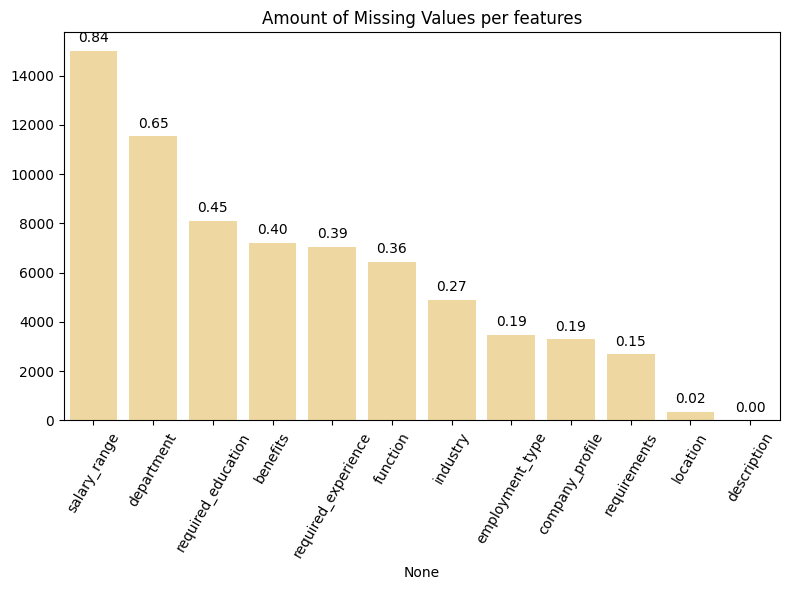

In [7]:
df_null_values=df.isnull().sum().sort_values(ascending=False).head(12)
plt.figure(figsize=(8,6),dpi=100)
ax=sns.barplot(x=df_null_values.index, y=df_null_values.values, color='#FCDC94')
plt.title('Amount of Missing Values per features')
for p in ax.patches:
    ax.annotate(format(p.get_height()/df.shape[0], '.2f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [8]:
df=df.rename(lambda col: col.strip(),axis=1).rename(lambda col : col.lower(),axis=1)

# null handeling
df['benefits']=df['benefits'].fillna("none benefits")
df['description']=df['description'].fillna("no descriptions")
df['requirements']=df['requirements'].fillna("none")
df['company_profile']=df['company_profile'].fillna("no company profile")
df['function']=df['function'].fillna("none")
df['industry']=df['industry'].fillna("none")
df['location']=df['location'].fillna("US")
#df['country']=df['location'].apply(lambda x: x.split(',')[0])

In [9]:
#title
df['title_length']=df['title'].apply(lambda x: len(x) if isinstance(x,str) else 0)
#df['title_punc_count']=df['title'].apply(lambda x: find_special_marks(x))
df['title']=df['title'].apply(lambda x: clean_text_from_wasted_chars(x))

#benefits
df['benefits_length']=df['benefits'].apply(lambda x: len(x) if isinstance(x,str) else 0)
#df['benefits_punc_count']=df['benefits'].apply(lambda x: find_special_marks(x) if isinstance(x,str) else 0)
df['benefits']=df['benefits'].apply(lambda x: clean_text_from_wasted_chars(x))

#description
df['description_length']=df['description'].apply(lambda x: len(x) if isinstance(x,str) else 0)
#df['description_punc_count']=df['description'].apply(lambda x: find_special_marks(x) if isinstance(x,str) else 0)
df['description']=df['description'].apply(lambda x: clean_text_from_wasted_chars(x))

#requirements
df['requirements_length']=df['requirements'].apply(lambda x: len(x) if isinstance(x,str) else 0)
#df['requirements_punc_count']=df['requirements'].apply(lambda x: find_special_marks(x) if isinstance(x,str) else 0)
df['requirements']=df['requirements'].apply(lambda x: clean_text_from_wasted_chars(x))

#company_profile
df['company_profile_length']=df['company_profile'].apply(lambda x: len(x) if isinstance(x,str) else 0)
#df['company_profile_punc_count']=df['company_profile'].apply(lambda x: find_special_marks(x) if isinstance(x,str) else 0)
df['company_profile']=df['company_profile'].apply(lambda x: clean_text_from_wasted_chars(x))

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_experience,required_education,industry,function,fraudulent,title_length,benefits_length,description_length,requirements_length,company_profile_length
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,Were Food52 and weve created a groundbreaking ...,Food52 a fastgrowing James Beard Awardwinning ...,Experience with content management systems a m...,none benefits,0,...,Internship,NaN,none,Marketing,0,16,13,905,852,885
1,2,Customer Service Cloud Video Production,"NZ, , Auckland",Success,NaN,90 Seconds the worlds Cloud Video Production S...,Organised Focused Vibrant AwesomeDo you hav...,What we expect from youYour key responsibility...,What you will get from usThrough being part of...,0,...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,41,1292,2077,1433,1286
2,3,Commissioning Machinery Assistant CMA,"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively seek...,Implement precommissioning and commissioning p...,none benefits,0,...,NaN,NaN,none,none,0,39,13,355,1363,879
3,4,Account Executive Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Resear...,EDUCATIONBachelors or Masters in GIS business ...,Our culture is anything but corporatewe have a...,0,...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,33,782,2600,1429,614
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION F...,QUALIFICATIONSRN license in the State of Texas...,Full Benefits Offered,0,...,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,19,21,1520,757,1628


# EDA

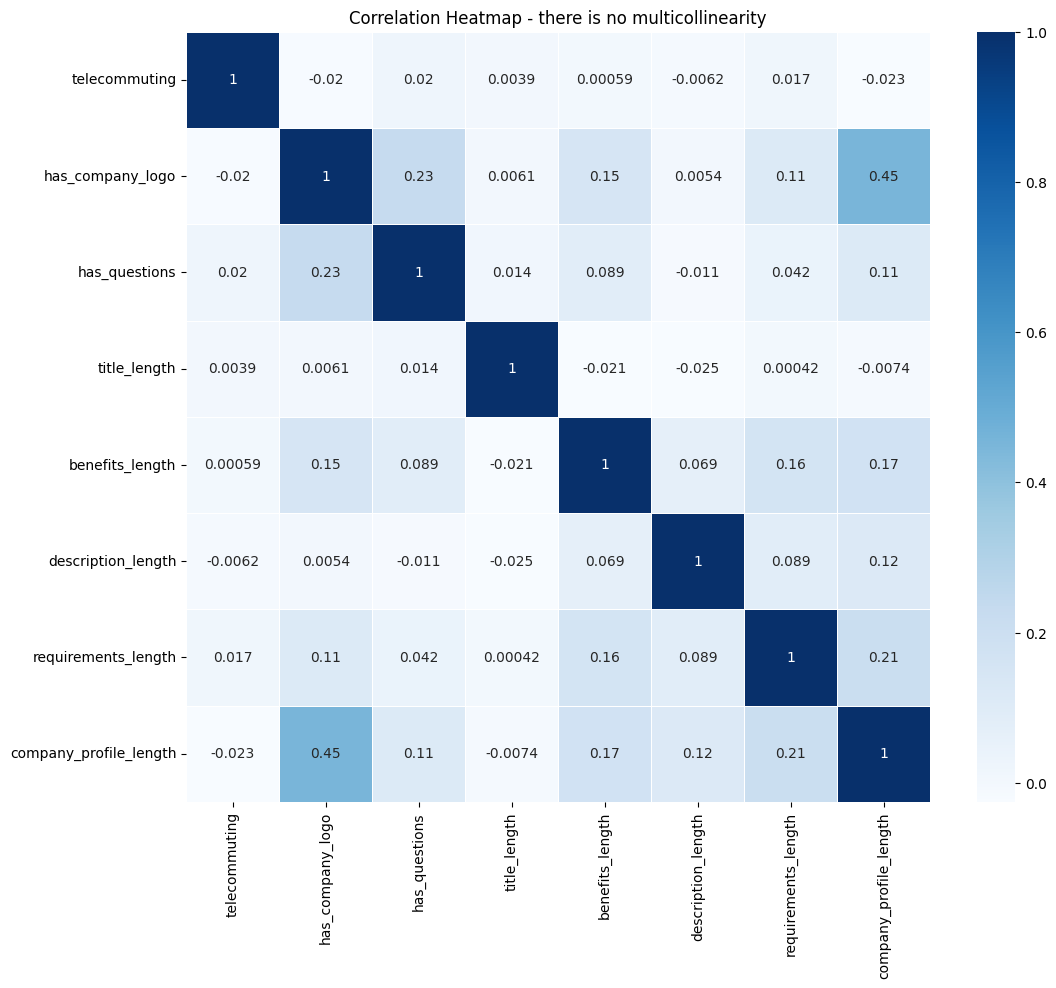

In [8]:
plt.figure(figsize=(12,10),dpi=100)
plt.title("Correlation Heatmap - there is no multicollinearity")
sns.heatmap(data=df.select_dtypes('number').drop(columns=['fraudulent','job_id']).corr(),annot=True,linewidth=0.7,cmap='Blues')
plt.show()

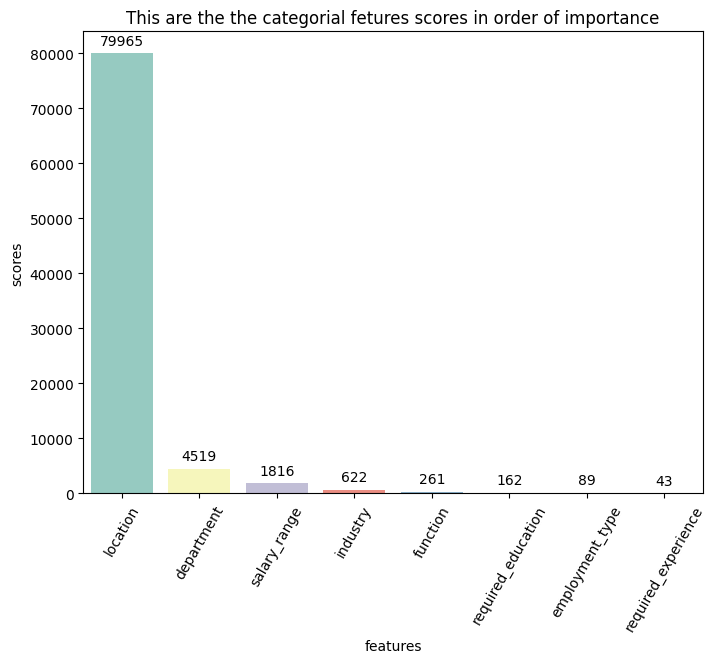

In [9]:
# labeling the categorical features
encoder=LabelEncoder()
X_encoded=df[['location', 'department', 'salary_range', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']]
for col in X_encoded.columns:
    X_encoded[col] = encoder.fit_transform(X_encoded[col])

# Encode the categorical target variable
encoder_target = LabelEncoder()
y_encoded = encoder_target.fit_transform(df['fraudulent'])

# Create an instance of SelectKBest with the chi2 test
X_data_new=SelectKBest(chi2, k=8).fit(X_encoded, y_encoded)


# create a dictioanry and append it with each feature and score
kbest_dict={}

for i in range(8):
  kbest_dict[X_data_new.get_feature_names_out()[i]]=X_data_new.scores_[i]

kbest_dict_sorted=sorted(kbest_dict.items(),key=lambda col: col[1],reverse=True)


#make it a df and plot it
df_kbest=pd.DataFrame(kbest_dict_sorted,columns=['features','scores'])
#print(f" This are the the fetures scores in order of importance \n{kbest_dict_sorted}")

plt.figure(figsize=(8,6),dpi=100)
ax=sns.barplot(data=df_kbest, x='features',y='scores',palette='Set3')
plt.title('This are the the categorial fetures scores in order of importance')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.xticks(rotation=60)
plt.show()

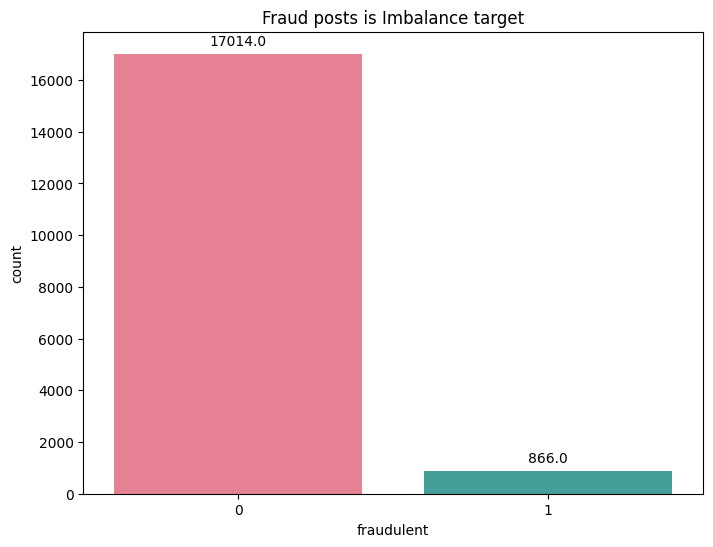

In [10]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Fraud posts is Imbalance target")
ax=sns.countplot(data=df,x='fraudulent',palette='husl')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.show()

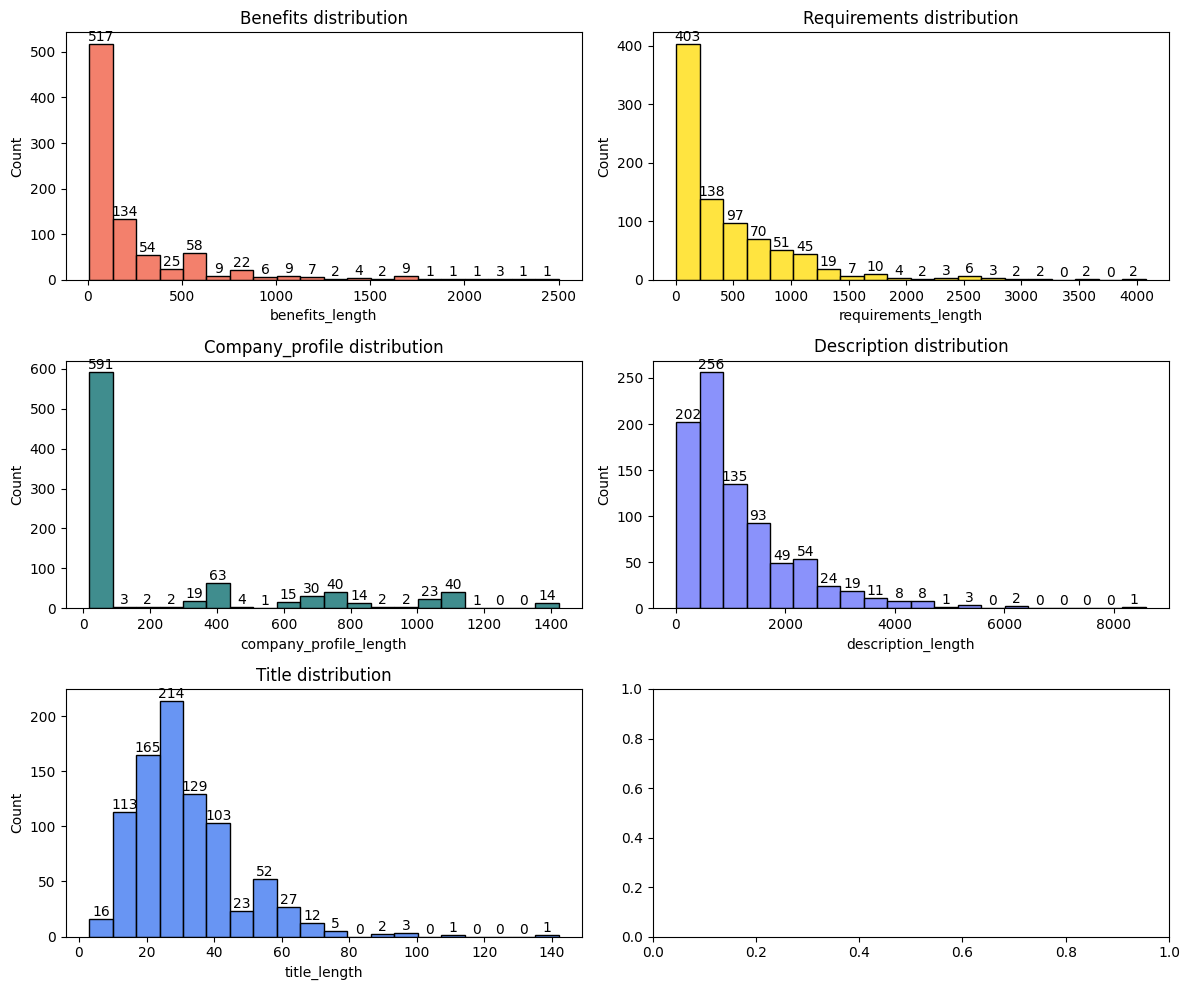

In [11]:
df_fraud=df[df['fraudulent']==1]
#creates the figure and divide it to 2 different plots
fig, ((ax1, ax2) ,(ax3,ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 10), dpi=100)

# Plot 1: Benefits distribution
ax1 = sns.histplot(data=df_fraud, x='benefits_length', bins=20, ax=ax1, color='#EF553B')
ax1.set_title('Benefits distribution')
ax1.bar_label(ax1.containers[0])

# Plot 2: Requirements distribution
ax2 = sns.histplot(data=df_fraud, x='requirements_length', bins=20, ax=ax2, color='#FFDB00')
ax2.set_title('Requirements distribution')
ax2.bar_label(ax2.containers[0])

# Plot 3: Company profile distribution
ax3 = sns.histplot(data=df_fraud, x='company_profile_length', bins=20, ax=ax3,color='#006769')
ax3.set_title('Company_profile distribution')
ax3.bar_label(ax3.containers[0])

# Plot 4: Description distribution
ax4 = sns.histplot(data=df_fraud, x='description_length', bins=20, ax=ax4,color='#636EFA')
ax4.set_title('Description distribution')
ax4.bar_label(ax4.containers[0])

ax5 = sns.histplot(data=df_fraud, x='title_length', bins=20, ax=ax5,color='#3572EF')
ax5.set_title('Title distribution')
ax5.bar_label(ax5.containers[0])

# Adjust spacing and show plot
plt.tight_layout()
plt.show()

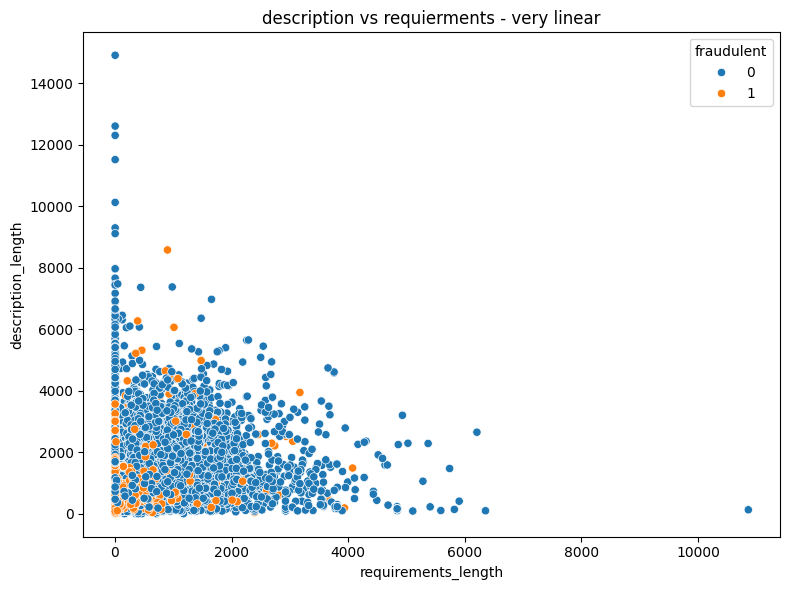

In [27]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("description vs requierments - very linear")
sns.scatterplot(data=df, x="requirements_length", y="description_length", hue="fraudulent")

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

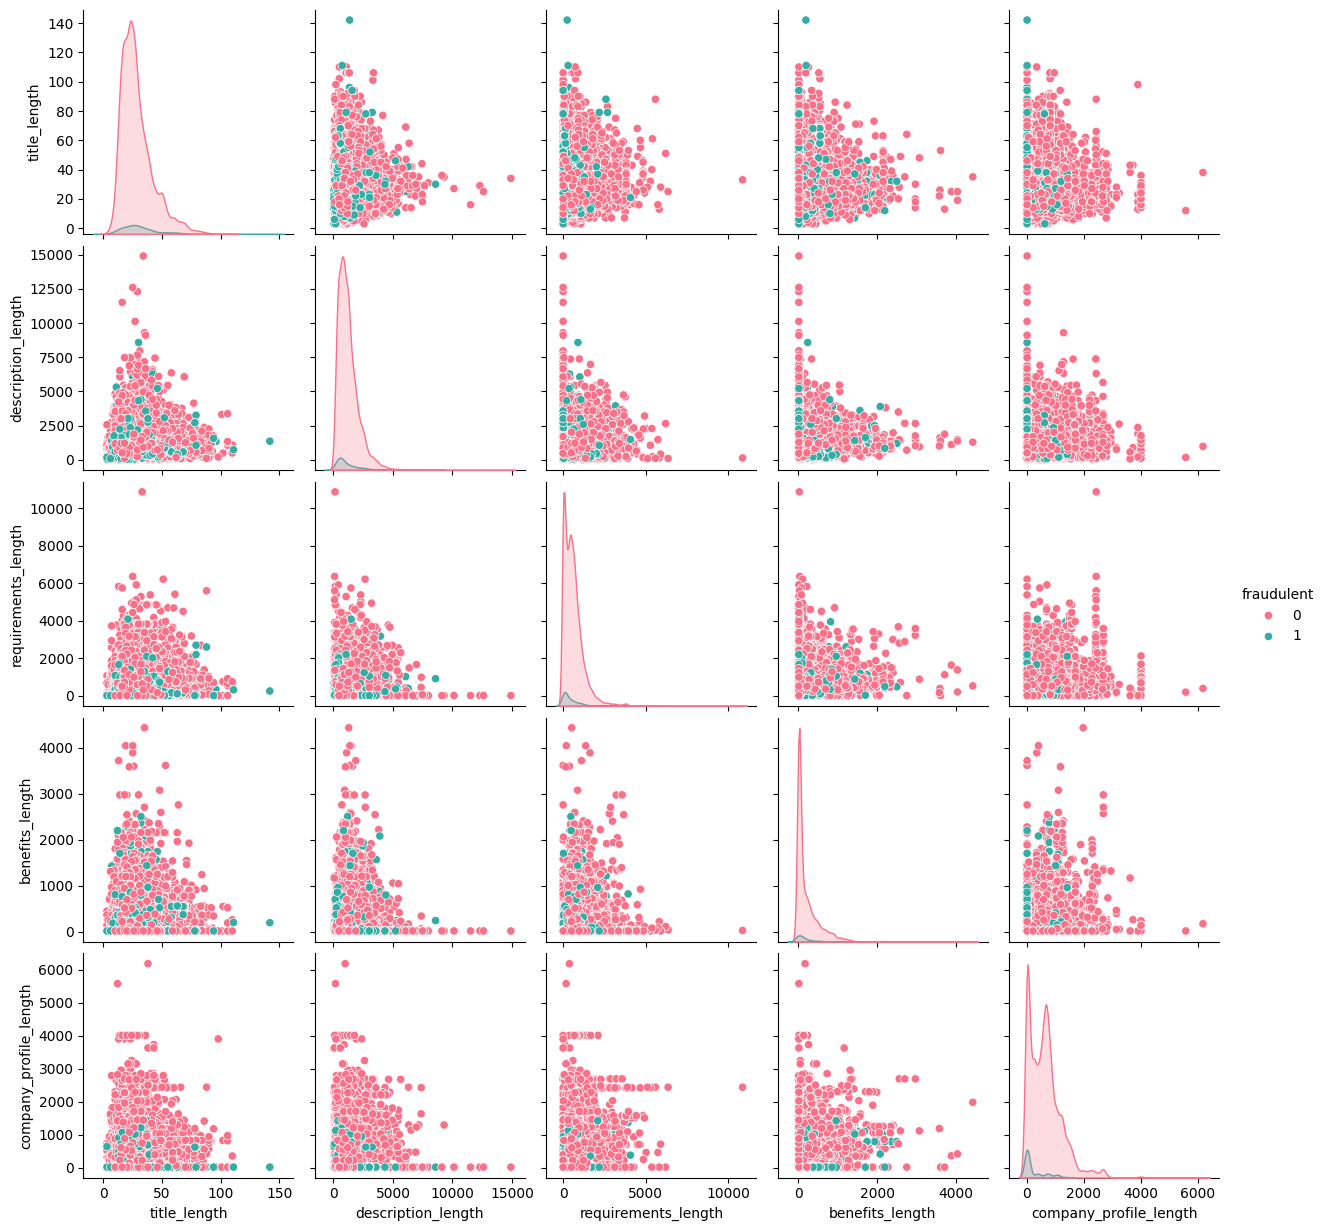

In [34]:
plt.figure(figsize=(8,6),dpi=100)
df_plot=df[['title_length','description_length','requirements_length','benefits_length','company_profile_length','fraudulent']]
sns.pairplot(data=df_plot,hue='fraudulent',palette='husl')

#plt.legend(bbox_to_anchor=(1.2,0.5))
plt.show()

In [ ]:
df_location=df.dropna(subset=['location'], axis=0)
df_location['location'].apply(lambda x: x.split(',')[0]).value_counts()

location
US    10656
GB     2384
GR      940
CA      457
DE      383
      ...  
SI        1
PE        1
SD        1
UG        1
KH        1
Name: count, Length: 90, dtype: int64

In [10]:
# final drop columns
df.drop(columns=['job_id',# just an index
                 'required_experience', # very low score with target according to chi2 test
                 'employment_type', # very low score with target according to chi2 test
                 'required_education', # very low score with target according to chi2 test
                 'salary_range', # too many nulls to handle
                 'department', # too many nulls to handle
                 'requirements','requirements_length'], # got an indication from EDA 
        inplace=True)

# Linear Model

## Preproccessing

In [18]:
# define X y matrices
X=df.drop(columns=['fraudulent','company_profile', 'description', 'benefits','title'])
y=df['fraudulent']

#split the data
X_train, X_test, y_train, y_test = split(X, y, test_size=0.25, random_state=42,shuffle=True)

In [13]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA

In [19]:
class myOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        """constructor"""
        super().__init__()
        self.ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
            
    def fit(self,X,y=None):
        """fit the non numric data on ohe object/bool"""
        self.ohe.fit(X.select_dtypes("object"))
        
        return self
    
    
    def transform(self,X):
        """transform the data we learned in the fit and combine it with the other data"""
        output=pd.DataFrame(self.ohe.transform(X.select_dtypes("object")))
        X_numeric=X.select_dtypes("number")
        return np.concatenate([output,X_numeric],axis=1)

In [20]:
my_pipe=Pipeline(steps=
                 [("ohe",myOneHotEncoder()),
                  ("scaler",StandardScaler())])

X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.transform(X_test)


### Clustering

In [33]:
def kmeans_elbow_method(df):
    """elbow method for k number of clusters"""
    ssd=[]
    for k in range(2,25):
        cluster_model=KMeans(n_clusters=k)
        cluster_model.fit(df)
    
        ssd.append(cluster_model.inertia_) #sum_squared_distances points--> distances from cluster center point to all other point in the cluster
    return ssd

cluster_ssd=kmeans_elbow_method(X_train_model)

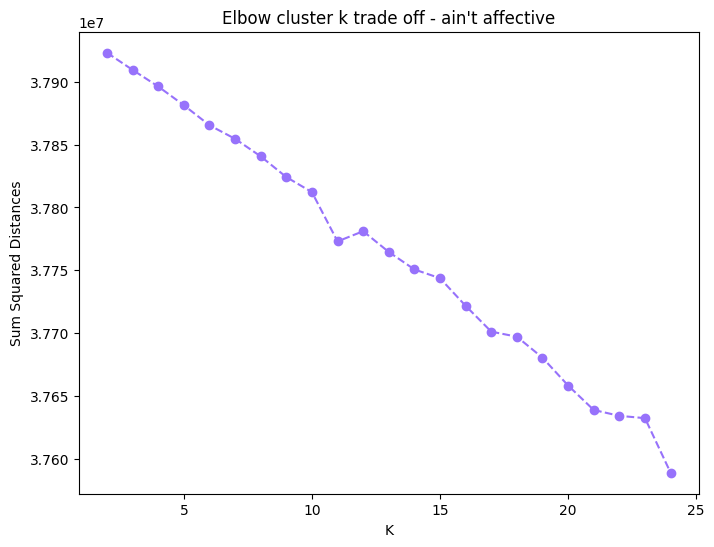

In [35]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Elbow cluster k trade off - ain't affective")
plt.plot(range(2,25),cluster_ssd,'o--', color='#9772FB')
plt.xlabel('K')
plt.ylabel('Sum Squared Distances')
plt.show()

## Model

### Logistic Regression

In [ ]:
#class_weight plot do like an elbow method to find the optimization
def calc_calss_weights_lr(X_train,y_train,X_test,y_test):
    class_weight_list=[]
    for i in np.linspace(0.05,0.95,30):
        lr=LogisticRegression(random_state=42, solver='saga',class_weight={0:1-i,1:i})

        lr.fit(X_train_model,y_train)
        y_pred=lr.predict(X_test_model)

        score=f1_score(y_test,y_pred)
        class_weight_list.append(score)
        
    return class_weight_list

model_scores_list=calc_calss_weights_lr(X_train_model,y_train,X_test_model,y_test)

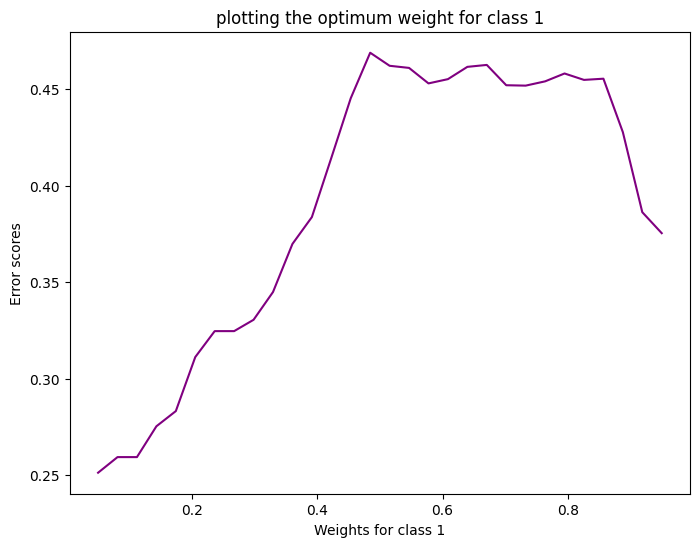

In [63]:

plt.figure(figsize=(8,6),dpi=100)
sns.lineplot(x=np.linspace(0.05,0.95,30),y=model_scores_list,color='#9772FB')
plt.title('plotting the optimum weight for class 1')
plt.xlabel('Weights for class 1')
plt.ylabel('F1 scores')
plt.grid()
plt.show()

In [17]:
# logistic regression
log_reg=LogisticRegression(random_state=42, solver='saga', class_weight='balanced')

# both hyperparameter are trying to find the right combination of regularization
c=np.linspace(0,1,20)
l1_ratio=np.linspace(0,1,20)

log_params={'C':c, "l1_ratio":l1_ratio}

log_rand=RandomizedSearchCV(log_reg,param_distributions=log_params,n_iter=10,scoring='f1',cv=5,verbose=1)

In [18]:
log_rand.fit(X_train_model,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=42,
                                                solver='saga'),
                   param_distributions={'C': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                                        'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
                   scoring='f1', verbose=1)

In [20]:
y_pred=log_rand.predict(X_test_model)
log_rand.predict_proba(X_test_model)[:,1]

array([0.24647397, 0.95944802, 0.1087485 , ..., 0.04436323, 0.00636197,
       0.09877565])

In [23]:
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      4247
           1       0.29      0.67      0.40       223

    accuracy                           0.90      4470
   macro avg       0.64      0.79      0.68      4470
weighted avg       0.95      0.90      0.92      4470



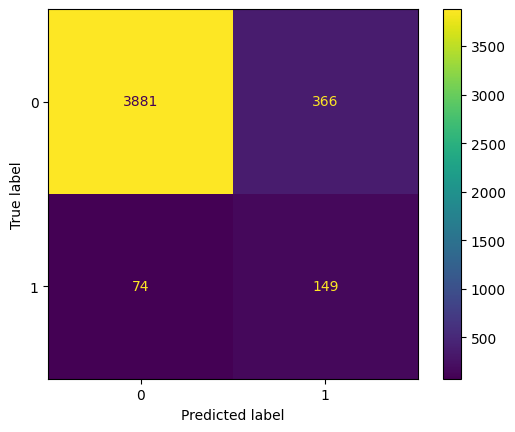

In [24]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=log_rand.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_rand.classes_)
disp.plot()
plt.show()

### XGBoost

In [24]:
#initiate the model
my_xgb=XGBClassifier()

#set the hyperparameters
learning_rate=[0.01,0.05,0.1]
max_depth=[2,3,5,7]
n_estimators=[100,150]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
min_samples_split=[3,5,7,10,20]
subsample=[0.3,0.5,0.8]

model_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'min_samples_split':min_samples_split,
            'max_features': max_features}


rand_model=RandomizedSearchCV(estimator=my_xgb,param_distributions=model_params,n_iter=10,scoring='f1',random_state=42)

In [25]:
rand_model.fit(X_train_model,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 5, 7],
                                        'max_features': [0.25, 0.5, 0.75, 1],
                                        'min_samples_split': [3, 5, 7, 10, 20],
                                        'n_estimators': [100, 150],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.3, 0.5, 0.8]},
                   random_state=42, scoring='f1')

In [26]:
y_pred=rand_model.predict(X_test_model)

In [27]:
rand_model.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'n_estimators': 150,
 'min_samples_split': 10,
 'max_features': 1,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.4}

In [28]:
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4247
           1       0.92      0.62      0.74       223

    accuracy                           0.98      4470
   macro avg       0.95      0.81      0.87      4470
weighted avg       0.98      0.98      0.98      4470



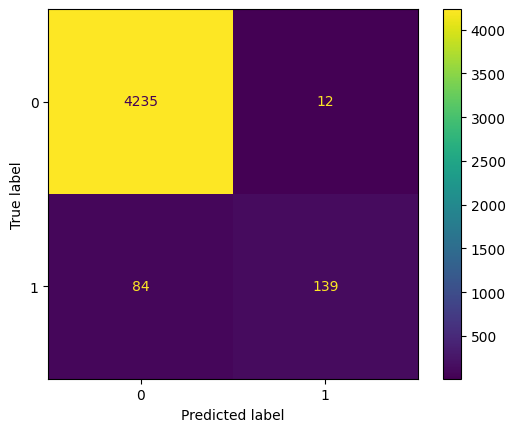

In [29]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=rand_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rand_model.classes_)
disp.plot()
plt.show()

Another way for operation to improve the model would consider using an under/over smapling techniques like SMOTE

# Textual Model

In [129]:
import nltk
from nltk.corpus import stopwords

my_stop_words=list(stopwords.words('english'))

In [109]:
# define X y matrices
X=df[['title','company_profile', 'description', 'benefits']]
y=df['fraudulent']

#split the data
X_train, X_test, y_train, y_test = split(X, y, test_size=0.25, random_state=42,shuffle=True)

## Preproccessing

In [130]:
class BagOfWordsVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self,feature):
        """Constructor - initialize transformer, the feature means a feature on the df"""
        super().__init__()
        self.feature=feature
        self.vectorizer=TfidfVectorizer(max_features=1000,min_df=10,analyzer='word',stop_words=my_stop_words)
        
    def fit(self,X,y=None):
        self.vectorizer.fit(X[self.feature])
        return self
        
    def transform(self,X):
        return self.vectorizer.transform(X[self.feature])

    
    def get_params(self, deep=True):
        return self.vectorizer.get_params()
    
    def set_params(self, **params):
        #By running the function set_params we setting the params of the vectorizer and not directly self.
        return self.vectorizer.set_params(**params)


In [131]:
title_vector = BagOfWordsVectorizer(feature="title")
benefits_vector = BagOfWordsVectorizer(feature="benefits")
description_vector = BagOfWordsVectorizer(feature="description" )
company_profile_vector = BagOfWordsVectorizer(feature="company_profile")


lgbm=LGBMClassifier(n_estimators=100,learning_rate=0.1)

feature_union = FeatureUnion([("title",title_vector),
                                  ("benefits", benefits_vector),
                                  ("description", description_vector),
                                  ("company_profile",company_profile_vector)
                                  #,("scaler",StandardScaler())
                                  ])

my_pipe=Pipeline(steps=
                 [("union", feature_union),
                  ("lgbm",lgbm)])


## Light GBM

In [132]:
my_pipe

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('title',
                                                 BagOfWordsVectorizer(analyzer='word',
                                                                      binary=False,
                                                                      decode_error='strict',
                                                                      dtype=<class 'numpy.float64'>,
                                                                      encoding='utf-8',
                                                                      input='content',
                                                                      lowercase=True,
                                                                      max_df=1.0,
                                                                      max_features=1000,
                                                                      min_df=10,
                                                                      ngram_range=(1,
                                                                                   1),
                                                                      norm='l2',
                                                                      preprocessor=None,
                                                                      smooth_idf=True,
                                                                      stop_words=['i',
                                                                                  'me',
                                                                                  'my',
                                                                                  'myself',...
                                                                                  'we',
                                                                                  'our',
                                                                                  'ours',
                                                                                  'ourselves',
                                                                                  'you',
                                                                                  "you're",
                                                                                  "you've",
                                                                                  "you'll",
                                                                                  "you'd",
                                                                                  'your',
                                                                                  'yours',
                                                                                  'yourself',
                                                                                  'yourselves',
                                                                                  'he',
                                                                                  'him',
                                                                                  'his',
                                                                                  'himself',
                                                                                  'she',
                                                                                  "she's",
                                                                                  'her',
                                                                                  'hers',
                                                                                  'herself',
                                                                                  'it',
                                                                                  "it's",
                                                                        

In [133]:
my_pipe.fit(X_train,y_train);

[LightGBM] [Info] Number of positive: 643, number of negative: 12767
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237511
[LightGBM] [Info] Number of data points in the train set: 13410, number of used features: 3324
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047949 -> initscore=-2.988474
[LightGBM] [Info] Start training from score -2.988474


In [136]:
y_pred=my_pipe.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4247
           1       0.98      0.68      0.80       223

    accuracy                           0.98      4470
   macro avg       0.98      0.84      0.90      4470
weighted avg       0.98      0.98      0.98      4470



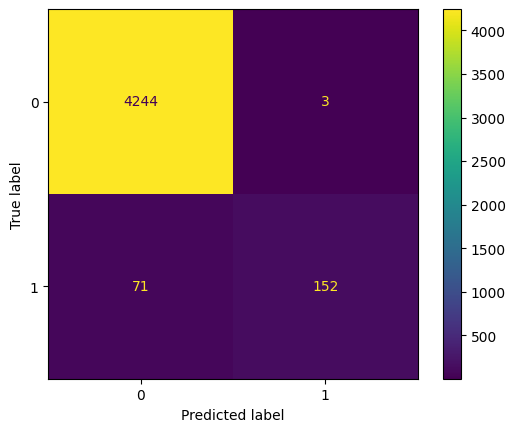

In [137]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=rand_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rand_model.classes_)
disp.plot()
plt.show()

In [98]:
tvector=TfidfVectorizer(max_features=1000,min_df=10,analyzer='word')
asdasd=tvector.fit_transform(df['benefits'])
df_ht_bow = pd.DataFrame(asdasd.toarray(),columns=tvector.get_feature_names_out())
ht_bow_sum = df_ht_bow.sum(axis=0)
ht_bow_sum.nlargest(200)

none           5581.288512
benefits       4821.809467
and            1309.738611
to              795.196861
the             784.278297
                  ...     
much             52.300006
pto              51.993831
challenging      51.886674
atmosphere       51.611975
were             51.433515
Length: 200, dtype: float64

# BERT

In [138]:
# define X y matrices
X=df[['title','company_profile', 'description', 'benefits']]
y=df['fraudulent']

#split the data
X_train, X_test, y_train, y_test = split(X, y, test_size=0.25, random_state=42,shuffle=True)

# Conclusion